<a href="https://colab.research.google.com/github/tjrgh822/class_itsystem/blob/master/hw4/up_down_stay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import  TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%203years.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20corona-2.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20corona.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage-2.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage-3.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/TSEC%20Taiwan%2050%20Historical%20Data.csv


In [0]:
#데이터 불러오기
b = pd.read_csv("KOSPI 200 Historical Data corona-2.csv")
b = b[['Open', 'High', 'Low', "Vol.", 'Price' ]]
b['Vol.'] = b['Vol.'].str.replace(pat='M', repl='e6', regex=False)
b['Vol.'] = b['Vol.'].str.replace(pat='K', repl='e3', regex=False)
corona_set = np.array(b.values, dtype= np.float32)[::-1]


y = pd.read_csv("KOSPI 200 Historical Data mortgage-3.csv")
y = y[['Open', 'High', 'Low', "Vol.", 'Price' ]]
y['Vol.'] = y['Vol.'].str.replace(pat='M', repl='e6', regex=False)
y['Vol.'] = y['Vol.'].str.replace(pat='K', repl='e3', regex=False)
mortgage_set = np.array(y.values, dtype= np.float32)[::-1]


three_years = pd.read_csv("KOSPI 200 Historical Data 3years.csv")
three_years = three_years[['Open', 'High', 'Low', "Vol.", 'Price' ]]
three_years['Vol.'] = three_years['Vol.'].str.replace(pat='M', repl='e6', regex=False)
three_years['Vol.'] = three_years['Vol.'].str.replace(pat='K', repl='e3', regex=False)
year = np.array(three_years.values, dtype= np.float32)[::-1]



In [0]:
#model select
'''
Option :
LSTM, DNN
'''
model_select = 'DNN' 

#hyper param
'''seq_length = 20 # 총 몇일의 날짜를 window로 설정할 것인지
data_dim = 5 # 하루에 high, low, open, close, volume 의 데이터를 넣겠다.
hidden_dim = 10 # 각 LSTM cell의 output dimension.
output_dim = 2 # up, down
learning_rate = 0.01
iterations = 500
batch = 10000 # 10000 이상이면 batch 없다'''


seq_length = 5 # 총 몇일의 날짜를 window로 설정할 것인지
data_dim = 5 # 하루에 high, low, open, close, volume 의 데이터를 넣겠다.
hidden_dim = 5 # 각 LSTM cell의 output dimension.
output_dim = 2 # up, down
learning_rate = 0.01
iterations = 500
batch = 10000 # 10000 이상이면 batch 없다

#data select
''' 
Option : 
dataset1  3years(70%) - 3years(30%)
dataset2  mortgage – corona
dataset3  corona - corona
'''
data_select = 'dataset3'

if data_select == 'dataset1':
  data_set = year
  train_size = int(len(data_set) * 0.7) # 70퍼센트만 training set 으로 만듬
  origin_train_set = data_set[0:train_size]
  origin_test_set = data_set[train_size - seq_length:]
elif data_select == 'dataset2':
  origin_train_set = mortgage_set
  origin_test_set = corona_set
elif data_select == 'dataset3':
  data_set = corona_set
  train_size = int(len(data_set) * 0.7) # 70퍼센트만 training set 으로 만듬
  origin_train_set = data_set[0:train_size]
  origin_test_set = data_set[train_size - seq_length:]


In [0]:
def minmax_scaler(data):
  normalized_data = np.zeros((data.shape[0], 1))
  for i in range(data.shape[1]):
    d = data[:, i]
    numerator = d - np.min(d, 0)
    denominator = np.max(d, 0) - np.min(d, 0)
    normalized_data = np.append(normalized_data, (numerator / (denominator + 1e-7)).reshape(-1, 1), axis = 1)
  normalized_data = np.delete(normalized_data, 0, axis=1)
  return normalized_data

'''
def minmax_scaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator + 1e-7)
'''
def build_dataset(origin_time_series, time_series, seq_length):
  dataX = []
  dataY = []
  percent = []
  for i in range(0, len(time_series) - seq_length):
    _x = time_series[i:i+seq_length, :]
    ay = origin_time_series[i+seq_length, [-1]] # 내일종가
    cy = origin_time_series[i+seq_length-1, [-1]] # 오늘종가
    _percent = ay/cy
    if (_percent - 1) > 0:
      _y = 1
    else:
      _y = 0
 
    #print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)
    percent.append(_percent)
  #print(dataX)
  return np.array(dataX), np.array(dataY), np.array(percent)


#scaling 작업 이유 : 주가 -> 800 정도되는 데이터, 거래랑 -> 10000만 정도 되는 숫자
#이러한 scaling까지 예측해야되는 부담을 덜어주기 위해 normalization 하게 만듬
train_set = minmax_scaler(origin_train_set)
test_set = minmax_scaler(origin_test_set)

trainX, trainY, train_percent = build_dataset(origin_train_set, train_set, seq_length)
testX, testY, test_percent = build_dataset(origin_test_set, test_set, seq_length)

class CustomDataset(Dataset): 
  def __init__(self, x_data, y_data, model):
    if model == 'LSTM':
      self.x_data = x_data
      self.y_data = y_data.reshape(-1, 1)
    if model == 'DNN':
      self.x_data = x_data.reshape(-1, data_dim*seq_length)
      self.y_data = y_data.reshape(-1, 1)
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = torch.FloatTensor(self.x_data[idx] )
    y = torch.LongTensor(self.y_data[idx])
    return x, y


In [487]:
#model

class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first=True)
    self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim*2, bias = True)
    self.fc2 = torch.nn.Linear(hidden_dim*2, hidden_dim*2, bias = True)
    self.fc3 = torch.nn.Linear(hidden_dim*2, output_dim, bias = True)
    self.dropout = torch.nn.Dropout(p=0.3)
    self.relu = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax()
  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.relu(x[:, -1])
    x = self.dropout(x)
    
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc3(x)
    x = self.softmax(x)
    return x

class linear_regression(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(linear_regression, self).__init__()

    self.fc1 = torch.nn.Linear(input_dim, hidden_dim*4, bias = True)
    self.fc2 = torch.nn.Linear(hidden_dim*4, hidden_dim*4, bias = True)
    self.fc3 = torch.nn.Linear(hidden_dim*4, output_dim, bias = True)

    self.dropout = torch.nn.Dropout(p=0.2)
    self.relu = torch.nn.ReLU()
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc3(x)
    return x



<class '__main__.linear_regression'>


In [0]:
#model select
if model_select == 'LSTM':
  net = Net(data_dim, hidden_dim, output_dim , 1)

if model_select == 'DNN':
  net = linear_regression(data_dim* seq_length, hidden_dim* seq_length, output_dim, 1)

#criterion, optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

#custom data set
trainset = CustomDataset(trainX, trainY, model_select)
testset = CustomDataset(testX, testY, model_select)
trainloader = DataLoader(trainset, batch_size = max(batch, len(trainset)), shuffle = False, num_workers= 1)
val_trainloader = DataLoader(trainset, batch_size =  len(trainset), shuffle = False, num_workers= 1)

testloader = DataLoader(testset, batch_size = len(trainset), shuffle = False, num_workers= 1)


epochs : 0, loss : 0.6936 acc : 0.5132 val_acc : 0.6
epochs : 50, loss : 0.6222 acc : 0.5087 val_acc : 0.4971
epochs : 100, loss : 0.5739 acc : 0.509 val_acc : 0.4971
epochs : 150, loss : 0.5933 acc : 0.508 val_acc : 0.5086
epochs : 200, loss : 0.5278 acc : 0.509 val_acc : 0.4914
=======================best val = 0.4914
=======================best val = 0.4971
=======================best val = 0.5029
epochs : 250, loss : 0.4883 acc : 0.509 val_acc : 0.4857
=======================best val = 0.52
=======================best val = 0.5257
=======================best val = 0.5314
epochs : 300, loss : 0.5167 acc : 0.5076 val_acc : 0.4971
epochs : 350, loss : 0.5372 acc : 0.509 val_acc : 0.4971
epochs : 400, loss : 0.5247 acc : 0.509 val_acc : 0.4971
epochs : 450, loss : 0.4977 acc : 0.509 val_acc : 0.4971


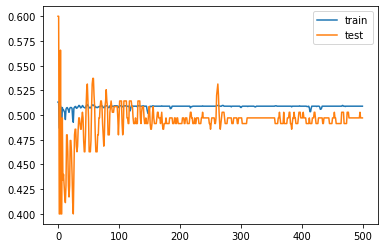

train : 0.5096952908587258, val : 0.5314285714285715


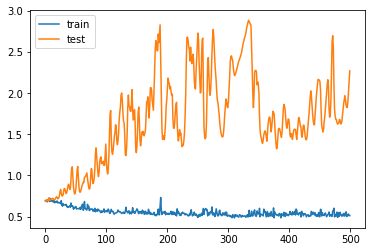

In [484]:
torch.manual_seed(0)

hist_acc, hist_val_acc = [], []
hist_loss, hist_val_loss = [],[]
best, best_train = 0, 0
for i in range(iterations):
  net.train()
  for x, y in trainloader:
    optimizer.zero_grad()
    outputs = net(x)
    
    loss = criterion(outputs.view(-1, 2), y.view(-1))

    loss.backward()
    optimizer.step()

  net.eval()
  acc = []
  for xx, yy in val_trainloader:
    outputs = net(xx).data.numpy()
    outputs = np.argmax(outputs, axis=1).reshape(-1, 1)
    acc = np.average(outputs == trainY)

  for tx, ty in testloader:
    predict = net(tx)
    val_loss = criterion(predict.view(-1, 2), torch.LongTensor(testY).view(-1))

  predict = np.argmax(predict.data.numpy(), axis=1).reshape(-1, 1)
  val_acc = np.average(predict == testY)

  hist_loss.append(loss.item())
  hist_val_loss.append(val_loss.item())

  if i % 50 == 0:
    print(f'epochs : {i}, loss : {loss.item():.4} acc : {acc:.4} val_acc : {val_acc:.4}')
  #print(predict[:20].reshape(-1))
  hist_acc.append(acc)
  hist_val_acc.append(val_acc)

  if best < val_acc and i > 200:
    torch.save(net.state_dict(), 'best')
    print(f'=======================best val = {val_acc:.4}')
    best = val_acc
    best_train = acc

torch.save(net.state_dict(), 'last')

plt.plot(hist_acc)
plt.plot(hist_val_acc)
plt.legend(['train', 'test'])
plt.show()

plt.plot(hist_loss)
plt.plot(hist_val_loss)
plt.legend(['train', 'test'])
plt.show
print(f'train : {best_train}, val : {best}')

[[ 5.398158  -5.5854177]
 [ 5.3375835 -5.5331297]
 [ 4.95308   -5.128267 ]
 [ 4.4982977 -4.6544127]
 [ 3.2507875 -3.3626628]
 [ 3.6845963 -3.811044 ]
 [ 3.6068976 -3.7286367]
 [ 2.834142  -2.927565 ]
 [ 2.5227635 -2.6059732]
 [ 2.4750073 -2.5589912]]


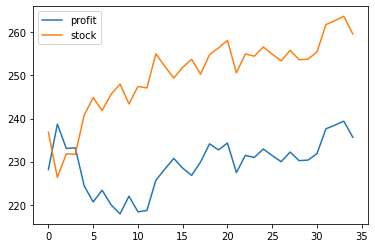

[[-0.1795304   0.08232577]
 [-0.18082145  0.08020325]
 [-0.1766569   0.08823456]
 [-0.18251216  0.07341507]
 [-0.18200886  0.08289925]
 [-0.174899    0.08954491]
 [-0.1781542   0.08553819]
 [-0.18041305  0.06064265]
 [-0.16767693  0.09769233]
 [-0.17849633  0.07570046]]


In [485]:
net.load_state_dict(torch.load('last'))
for x, _ in testloader:
  predict = np.argmax(net(x).data.numpy(), axis=1)
  print(net(x).data.numpy()[:10])

profit = origin_test_set[seq_length-1,-1]
profit_hist = []
for i, p in enumerate(predict):
  if p == 0:
    profit = profit / test_percent[i]
    profit_hist.append(profit)
  elif p == 1:
    profit = profit * test_percent[i]
    profit_hist.append(profit)

#profit_hist = np.append( np.ones(seq_length) * origin_test_set[seq_length-1,-1], np.array(profit_hist))

plt.plot(profit_hist)
plt.plot(origin_test_set[seq_length:,-1])
plt.legend(['profit', 'stock'])
plt.show()

for x, _ in val_trainloader:
  print(net(x).data.numpy()[:10])



In [486]:
profit_hist[-1] / origin_test_set[seq_length-1,-1]

array([1.013798], dtype=float32)